# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras

In [7]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(x,y,z,3)

# Define model
model_final = Sequential()

model_final.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_final.add(Activation('relu'))
model_final.add(Dropout(0.25))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_final.add(Flatten())

model_final.add(Dense(nb_dense[0], activation='relu'))
model_final.add(Dropout(0.5))

model_final.add(Dense(nb_dense[1], activation='relu'))
model_final.add(Dropout(0.5))

#softmax layer
model_final.add(Dense(nb_dense[2], activation='softmax'))

In [8]:
optimiser = keras.optimizers.Adam() #write your optimizer
model_final.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_final.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [12]:
final = model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 3/21 [===>..........................] - ETA: 1:32 - loss: 3.5824 - categorical_accuracy: 0.1667Batch:  4 Index: 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 82s 4s/step - loss: 2.1285 - categorical_accuracy: 0.1936 - val_loss: 1.5236 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-07-1317_46_35.256908/model-00001-2.13643-0.19155-1.52359-0.23000.h5
Epoch 2/20
21/21 [==============================] - 51s 2s/step - loss: 1.5367 - categorical_accuracy: 0.2816 - val_loss: 1.3881 - val_categorical_accuracy: 0.3750

Epoch 00002: saving model to model_init_2020-07-1317_46_35.256908/model-00002-1.53667-0.28157-1.38809-0.37500.h5
Epoch 3/20
21/21 [==============================] - 45s 2s/step - loss: 1.4225 - categorical_accuracy: 0.3790 - val_loss: 1.2886 - val_categorical_accuracy: 0.3750

Epoch 00003: saving model to model_init_2020-07-1317_46_35.256908/model-00003-1.42451-0.37705-1.28858-0.37500.h5
Epoch 4/20
21/21 [==============================] - 44s 2s/step - loss: 1.3418 - categorical_accuracy: 0.4010 - val_loss: 1.2187 - val_categorical_accuracy: 0.5000

Epoch 00004:

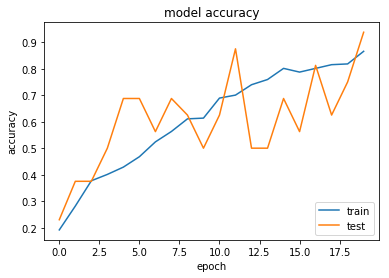

In [15]:
# visualise training history
from matplotlib import pyplot as plt

plt.plot(final.history['categorical_accuracy'])
plt.plot(final.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### So, the best validation accuracy of 93.75% achived with a batch size of 32 and with 20 epochs...